# Denoising example

This notebook demonstrates how to use Markov random fields(MRFs) to denoise(low pass filter) images.

In [56]:
import cv2
import networkx as nx
import numpy as np

from typing import List, Union
import copy

from matplotlib import pyplot as plt
from torchvision import datasets
from dataclasses import dataclass, field
import time



To demonstrate the setup we first need som base classes:

In [57]:
@dataclass(frozen=True)
class Node:
    creationtime: float = field(default_factory=time.perf_counter)


@dataclass(frozen=True)
class RandomNode(Node):
    pass


@dataclass(frozen=True)
class ObservedNode(Node):
    pass


@dataclass
class Factor:
    def evalueate(self):
        raise NotImplemented

    def condition(self):
        raise NotImplemented


@dataclass
class BinaryFactor(Factor):
    a: Union[RandomNode, ObservedNode]
    b: Union[RandomNode, ObservedNode]

    def get_other_node(self, x):
        if x == self.a:
            return self.b
        elif x == self.b:
            return self.a
        else:
            raise NotImplemented


@dataclass
class MRF:
    nodes: List[Node]

    def __init__(self):
        self.nodes = []
        self.graph = nx.Graph()

    def add_factor(self, factor: BinaryFactor):
        self.graph.add_edge(factor.a, factor.b, factor=factor)

    def add_node(self, node: Node):
        self.nodes.append(node)
        self.graph.add_node(node, node=node)

In [58]:
class UnknownPixelNode(RandomNode):
    value: float

    def __init__(self, value):
        super().__init__()
        self.value = value


class KnownPixelNode(ObservedNode):
    value: float

    def __init__(self, value):
        super().__init__()
        self.value = value


class LatentPixelFactor(BinaryFactor):

    def __init__(self, gamma, beta, xn: UnknownPixelNode, xm: UnknownPixelNode):
        self.gamma = gamma
        self.beta = beta
        self.a = xn
        self.b = xm

    def evalueate(self):
        # TODO: Account for beta
        return self.gamma * (self.a.value - self.b.value) ** 2

    def condition(self):
        pass


class ImageConsistencyFactor(BinaryFactor):

    def __init__(self, sigma, xn: UnknownPixelNode, dn: KnownPixelNode):
        self.sigma = sigma
        self.a = xn
        self.b = dn

    def evalueate(self):
        return ((self.a.value - self.b.value) ** 2) / (2 * self.sigma ** 2)

    def condition(self):
        if self.a is None:
            raise ValueError("Can not condition on deterministic variable")
        if self.b is None:
            return

In [59]:
## Functions for converting between the MRF datastructure and images.

In [60]:
def mrf_from_img(img: np.ndarray, beta, gamma, sigma) -> MRF:
    node_grid = []
    mrf = MRF()
    for x0 in range(img.shape[0]):
        node_grid.append([])
        for x1 in range(img.shape[1]):
            new_random_node = UnknownPixelNode(img[x0, x1])
            node_grid[x0].append(new_random_node)
            new_deterministic_node = KnownPixelNode(img[x0, x1])
            mrf.add_node(new_random_node)
            mrf.add_node(new_deterministic_node)

            new_intensity_factor = ImageConsistencyFactor(sigma, new_random_node, new_deterministic_node)
            mrf.add_factor(new_intensity_factor)

            if x0 > 0:
                new_left_factor = LatentPixelFactor(gamma, beta, new_random_node, node_grid[x0 - 1][x1])
                mrf.add_factor(new_left_factor)
            if x1 > 0:
                new_up_factor = LatentPixelFactor(gamma, beta, new_random_node, node_grid[x0][x1 - 1])
                mrf.add_factor(new_up_factor)

    return mrf


def img_from_mrf(mrf, shape) -> np.ndarray:
    img = np.array([node.value for node in mrf.nodes if isinstance(node, RandomNode)]).reshape(shape)
    return img

Now that we have the base logic defined we can try to illustrate how we will use this to work with images.

Files already downloaded and verified


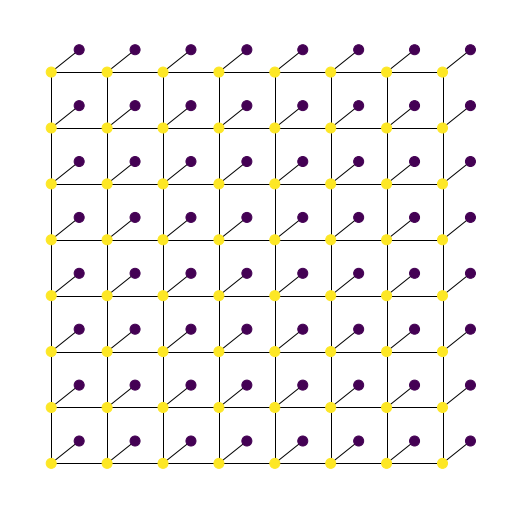

In [61]:
dataset = datasets.CIFAR10(
    root="data",
    train=True,
    download=True,
)
pic = dataset[0][0]
img = np.array(pic)
img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
img = cv2.pyrDown(img)
img = cv2.pyrDown(img)

cv2.imshow("Example_img", img)

gamma = 100
beta = 2000
sigma = 1
mrf = mrf_from_img(img, beta, gamma, sigma)

plt.figure(figsize=(20,20,))
subax1 = plt.subplot(121)
subax1.set_aspect(1)
pos_dict = dict([(node, (4* ((i / 2) % img.shape[0]), 4* (((i / 2) // img.shape[0]) + int(isinstance(node, KnownPixelNode)) * 0.4))) for (i, node,) in enumerate(mrf.nodes)])
color_array = [0 if isinstance(node, KnownPixelNode) else 1 for node in mrf.graph.nodes]
nx.draw(mrf.graph,pos_dict, node_color=color_array, node_size=100)

We see here how the image is reperesented as a MRF. The yellow nodes are the stochastic image pixels that we are going to estimate. The blue nodes are the pixel values in the noisy image. As you see from the graph are the yellow nodes connected to their neighbours and their corresponding blue node. In the MRF context this means that each yellow node depends on its neighbouring pixels (4-conectivity) and the corresponding noisy pixel.

We will consider the task of denoising an image as the process of estimating the "true" image from the noisy image. I.e. we wish to find the MAP-estimate(yellow nodes) from the noisy image(blue nodes). For simplicity, we instead optimize over the log likelihood. If we assume that the noise in the image is gaussian the the
$$ {argmax}_x log (p(x)) = {argmax}_x \sum_c \theta_c(x_c) $$

where $x$ is the state and $\theta$ is the factors(cliques). Note that the MAP-solution does not depend on the normalization constant.

For our use case there are two kinds of factors, the factors between neighbouring yellow nodes and the factors between a yellow node and its corresponding blue node. The smoothing factors(yellow-yellow) are defined as this:

$$V_{mn} = \gamma min((x_n - x_m)^2, \beta) $$

The part $(x_n - x_m)^2$ is due to the assumption that the noise is gaussian uncorrelated. The $\beta$ is to avoid smoothing out strong edges. This option of making more complex factors is one of the benefits compared to just apply gaussian smoothing on the whole image.

The factor between the estimated pixel value and the noisy pixel value is also a least squares expressian due to the gaussian noise assumption, but with some other parameters to better be able to tune this:

$$ V_n = \frac{(x_n - d_n)^2}{2\sigma^2}$$

where $d_n$ is the noisy pixel value and $x_n$ is the estimated pixel value. $\gamma$, $\sigma$ and $\beta$ are all constants.

The resulting log likelihood then becomes
$$
log(p(x)) = \frac{(x_n - d_n)^2}{2\sigma^2} + \sum_{x_m \in \mathcal{N}_{x_n}} \gamma min((x_n - x_m)^2, \beta)
$$

Where $\mathcal{N}_{x_n}$ is the neighbourhood of $x_n$, i.e. the nodes of which it has an edge to.

## ICM (Iterated conditional modes)

One very simple algorithm for finding the MAP-estimate is ICM. The basic idea is to start off with some initial values for the values to be estimated and iteratively estimate each value from the current estimate for its neighbours.

In [62]:
def icm(mrf: MRF):
    iterations = 5
    for i in range(iterations):
        new_mrf = copy.deepcopy(mrf)
        for e in range(len(mrf.nodes)):
            if isinstance(mrf.nodes[e], RandomNode):

                latentPixelFactors = []
                observedPixelFactor = None
                adjecent_factors = mrf.graph.adj[mrf.nodes[e]]
                for neighbour in adjecent_factors:
                    if isinstance(neighbour, UnknownPixelNode):
                        latentPixelFactors.append(adjecent_factors[neighbour]['factor'])
                    elif isinstance(neighbour, KnownPixelNode):
                        observedPixelFactor = adjecent_factors[neighbour]['factor']
                    else:
                        raise NotImplementedError
                new_mrf.nodes[e].value = optimal_pixel_value(mrf.nodes[e],
                                                             latentPixelFactors,
                                                             observedPixelFactor)
        mrf = new_mrf
    return mrf

A central part of this algorithm is the function `optimal_pixel_value` which calculates the optimal value of a single pixel given its neighbours. This is found analytically for this particular problem and given by:

$$ x_n = \frac{d_n + 2 \gamma \sigma^2 \sum_{x_m \in \mathcal{N}_{x_n}}x_m}{1 + 2\gamma \sigma^2 M}$$


In [63]:
def optimal_pixel_value(node_to_estimate: UnknownPixelNode,
                        smoothing_factors: List[LatentPixelFactor],
                        observed_image_factor: ImageConsistencyFactor):
    sum_of_neighbours = 0
    M = 0
    for neighbour_factor in smoothing_factors:
        if (float(neighbour_factor.get_other_node(node_to_estimate).value) - float(
                node_to_estimate.value)) ** 2 < neighbour_factor.beta:
            sum_of_neighbours += neighbour_factor.get_other_node(node_to_estimate).value
            M += 1
    # We assume that gamma is the same for all the neighbourfactors
    res = (observed_image_factor.get_other_node(node_to_estimate).value + 2 * smoothing_factors[0].gamma * (
            observed_image_factor.sigma ** 2) * sum_of_neighbours) / (
                  1 + 2 * smoothing_factors[0].gamma * M * (observed_image_factor.sigma ** 2))
    return res

We now show some examples of this algorithm applied to some images:

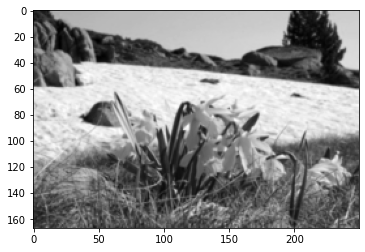

In [64]:
dataset = datasets.Country211(
    root="data",
    # annFile=False
    # train=True,
    download=True,
)
pic = dataset[2][0]
img = np.array(pic)
img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
img = cv2.pyrDown(img)
shape = img.shape
plt.imshow(img, cmap='gray' )

Then we can add some gaussian noise to the image:

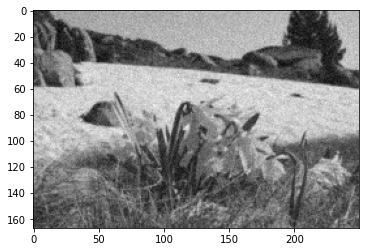

In [65]:
sigma = 10
gauss = np.random.normal(0,sigma,img.shape)
gauss = gauss.reshape(*img.shape)
img = img + gauss
plt.imshow(img, cmap='gray')

With our noise corrupted image we can try to recover our original:

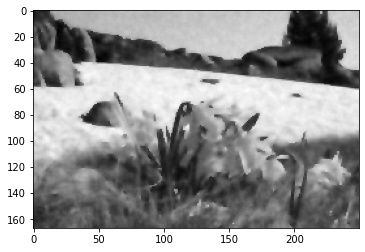

In [66]:
gamma = 0.01
beta = 40**2
sigma = 10

mrf = mrf_from_img(img, beta, gamma, sigma)
new_mrf = icm(mrf)

new_img = img_from_mrf(new_mrf, shape)
new_img = new_img.astype(float)
new_img = new_img / new_img.max()
plt.imshow(new_img, cmap='gray')

We see here that not only noise became smoothed out, but also high frequency features in the image itself. However, the sharp edges are conserved.